In [1]:
import numpy as np

from btgym import BTgymEnv
from gym import spaces
import backtrader as bt
from btgym.research import DevStrat_4_11, DevStrat_4_12

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
class SignalProvider():
    
    def __init__(self, env):
        self.env = env
        self.done = True
    
    def get_batch(self, batch_size):
        batch_ext = []
        batch_int = []
        batch_r = []
        while len(batch_r) < batch_size:
            if not self.done:
                o, r, self.done, i = env.step(env.action_space.sample())
            else:
                o = env.reset()
                r = 0
                self.done = False
            batch_ext.append(o['external'])
            batch_int.append(o['internal'])
            batch_r.append(r)
        return batch_ext, batch_int, batch_r
    
    def close(self):
        self.env.close()
        self.done = True

In [3]:
# Our Scale-state-before-tanh parameter of interest:
state_ext_scale = 1e3

# additional
state_int_scale = 1.0
reward_scale = 10.0

engine = bt.Cerebro()
engine.addstrategy(
    DevStrat_4_12,
    drawdown_call=10, # max % to loose, in percent of initial cash
    target_call=10,  # max % to win, same
    skip_frame=10,
    gamma=0.99,
    reward_scale=reward_scale,
    state_ext_scale=state_ext_scale,
    #state_int_scale=state_int_scale,
)
env = BTgymEnv(
    filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
    #filename='../examples/data/DAT_ASCII_EURUSD_M1_201703_1_10.csv',  # ten days
    #filename='../examples/data/test_bent_sine_1min_period1500_300_delta0002.csv',  # increasing sine freq
    #filename='../examples/data/test_sine_1min_period256_delta0002.csv',  # simple sine 
    #state_shape=dict(raw_state=spaces.Box(low=0,high=1,shape=(30,4))),
    engine=engine,
    skip_frame=10,
    verbose=0
) 
signal_provider = SignalProvider(env)

/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


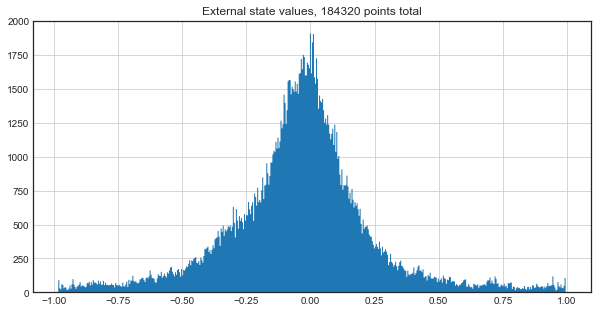

In [5]:
# Make it  256 -:- 1024 (takes a minute):
batch_size = 1024

batch_ext, batch_int, batch_r = signal_provider.get_batch(batch_size)
signal_provider.close()


# Distribution of values:
distr_ext = np.reshape(batch_ext, -1)
distr_int = np.reshape(batch_int, -1)
distr_r = np.asarray(batch_r)

plt.figure(num=0, figsize=(10, 5))
plt.title('External state values, {} points total'.format(distr_ext.shape[0]))
plt.grid(True)
fig = plt.hist(distr_ext, histtype='stepfilled', bins=500)

#plt.figure(num=1, figsize=(10, 5))
#plt.title('Reward values, {} points total'.format(distr_r.shape[0]))
#plt.grid(True)
#fig = plt.hist(distr_r, histtype='stepfilled', bins=500)


In [ ]:
signal_provider.close()


##### Properly scaled:
![Normal](./img/state_value_distr_ok.png)


##### Overscaled:
![Over](./img/state_value_distr_over.png)


##### Underscaled:
![Under](./img/state_value_distr_under2.png)